In [2]:
import math as m
import numpy as np
import matplotlib as mpl
from PIL import Image as im
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import sklearn.datasets as datasets

TEMPFILE_NAME = "temp.png"

def save_to_gif(filename, images, duration=100):
    images[0].save(
        filename,
        optimize=False,
        save_all=True,
        append_images=images[1:],
        loop=0,
        duration=duration,
    )

np.random.seed(1)

COLORS = np.array(['#9E005D', 'green', '#0D718C'])

# custom CMAP
cvals  = [0, .5, 1]
colors = ['#0D718C', 'white', '#9E005D']
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
CMAP = mpl.colors.LinearSegmentedColormap.from_list("", tuples, 100)

cvals  = [0, .5, 1]
colors = ['white', 'white', 'purple']
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
CMAP_PURPLE = mpl.colors.LinearSegmentedColormap.from_list("", tuples, 100)

cvals  = [0, .5, 1]
colors = ['white', 'white', 'green']
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
CMAP_GREEN = mpl.colors.LinearSegmentedColormap.from_list("", tuples, 100)

cvals  = [0, .5, 1]
colors = ['white', 'white', 'blue']
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
CMAP_BLUE = mpl.colors.LinearSegmentedColormap.from_list("", tuples, 100)

CENTERS = [[0, 0]]
STDEV = 1
DATA, _ = datasets.make_blobs(
        n_samples=200,
        centers=CENTERS,
        cluster_std=STDEV,
        random_state=1
    )
xlim_min = CENTERS[0][0] - 3 * STDEV
xlim_max = CENTERS[0][0] + 3 * STDEV
ylim_min = CENTERS[0][1] - 3 * STDEV
ylim_max = CENTERS[0][1] + 3 * STDEV

def generate_line_data(t, w1, w2, b):
    X = np.array(list(filter(lambda x : w1 * x[0] + w2 * x[1] + b < -.5 or w1 * x[0] + w2 * x[1] + b > .5, t)))
    Y = np.array([0 if w1 * x[0] + w2 * x[1] + b >= 0 else 2 for x in X])
    return X, Y

def sigmoid(x):
    e = np.exp(-x)
    return 1 / (1 + e)

def generate_3_classes_1D(SIZE):
    X = np.linspace(0, 5 * SIZE, SIZE) + np.random.randn(SIZE) * 4
    Y = np.array([0 if x < 18 else 1 if x < 60 else 2 for x in X])
    return X, Y

def generate_3_classes_2D(t, w1, w2):
    f1 = lambda x1, x2: w1[0] * x1 + w1[1] * x2
    f2 = lambda x1, x2: w2[0] * x1 + w2[1] * x2
    X = np.array(list(filter(lambda x : (f1(x[0], x[1]) < -.5 or f1(x[0], x[1]) > .5) and (f2(x[0], x[1]) < -.5 or f2(x[0], x[1]) > .5), t)))
    Y = np.array([0 if f1(x[0], x[1]) >= 0 and f2(x[0], x[1]) >= 0 else 1 if (f1(x[0], x[1]) < 0 and f2(x[0], x[1]) >= 0) else 2 for x in X])
    return X, Y

# OTHER FUNCTIONS
def generate_circle_data(t):
    X = np.array(list(filter(lambda x : (x[0] - CENTERS[0][0])**2 + (x[1] - CENTERS[0][1])**2 < 1 or (x[0] - CENTERS[0][0])**2 + (x[1] - CENTERS[0][1])**2 > 1.5, t)))
    Y = np.array([0 if (x[0] - CENTERS[0][0])**2 + (x[1] - CENTERS[0][1])**2 >= 1 else 2 for x in X])
    return X, Y

def generate_square_data(t):
    X = np.array(list(filter(lambda x : x[0]**2 - x[1] < .4 or x[0]**2 - x[1] > 1.1, t)))
    Y = np.array([1 if x[0]**2 - x[1] >= .75 else 0 for x in X])
    return X, Y

def generate_curve_data(t):
    X = np.array(list(filter(lambda x : m.cos(4*x[0]) - x[1] < -.5 or m.cos(4*x[0]) - x[1] > .5, t)))
    Y = np.array([1 if m.cos(4*x[0]) - x[1] >= 0 else 0 for x in X])
    return X, Y

## Sigmoid Sum of Squares Errors

In [4]:
def f(x1, x2, C):
    return C * x1 - C * x2

DATA, _ = datasets.make_blobs(
        n_samples=2000,
        centers=CENTERS,
        cluster_std=STDEV,
        random_state=1
    )
COLORS = np.array(['#0D718C', '#9E005D'])
X, Y = generate_line_data(DATA, 1, -1, 0)
Y[np.where(Y == 0)] = 1
Y[np.where(Y == 2)] = 0

def snap(Cs, rot_z, rot_xy, rot_ang):
    C = Cs[-1]
    xplot = np.linspace(-3, 3, 100)
    x, y = np.meshgrid(xplot, xplot)
    fig = plt.figure(figsize=(16, 8), constrained_layout=True, facecolor=None)
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.view_init(20 + rot_z, -135 - rot_ang, rot_xy)
    ax1.scatter(X[:,0], X[:,1], Y, color=COLORS[Y].tolist(), s=50, alpha=.5)
    ax1.plot(xplot, xplot, np.zeros_like(xplot) + .5, linestyle='--', linewidth=3, color='b')
    # ax.set_zlabel('Class Label / Sigmoid Output')
    ax1.plot_surface(x, y, sigmoid(f(x,y, C)), cmap=CMAP, alpha=.4, lw=0)
    # make the panes transparent
    ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax1.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax1.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax1.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    for (x1_i, x2_i, y_i) in zip(X[:, 0], X[:, 1], Y):
        sigmoid_value = sigmoid(f(x1_i, x2_i, C))
        ax1.plot([x1_i, x1_i], [x2_i, x2_i], [y_i, sigmoid_value], 'k--', zorder=0)

    ax1.set_xlabel('$x_1$', fontsize=15)
    ax1.set_ylabel('$x_2$', fontsize=15)
    ax1.set_title(r'$\sigma(C x_1 - C x_2)$'.replace("C", f'{C:.2f}'), fontsize=40)
    ax1.set_xlim(xlim_min, xlim_max)
    ax1.set_ylim(ylim_min, ylim_max)
    ax1.set_zlim(-.01, 1.01)

    errors = []
    for C in Cs:
        errors.append(np.sum((Y - sigmoid(f(X[:,0], X[:,1], C)))**2))

    ax2 = fig.add_subplot(122)
    ax2.set_title('Sum of squares of residuals vs Parameter Size')
    ax2.set_xlabel('Parameter Value')
    ax2.set_ylabel('Sum of squares of residuals')

    ax2.scatter(Cs, errors)
    ax2.scatter(Cs[-1], errors[-1], color='r', s=100)
    ax2.grid(True)

    fig.savefig(TEMPFILE_NAME)
    plt.close()

    return im.fromarray(np.asarray(im.open(TEMPFILE_NAME)))

images = []
sofar = []
for i in range(10, 100):
    sofar.append(i/10)
    images.append(snap(sofar, 0, 0, 20))

save_to_gif("000.gif", images, 10)

## Sigmoid Log Likelihood

In [3]:
def f(x1, x2, C):
    return C * x1 - C * x2

DATA, _ = datasets.make_blobs(
        n_samples=2000,
        centers=CENTERS,
        cluster_std=STDEV,
        random_state=1
    )
COLORS = np.array(['#0D718C', '#9E005D'])
X, Y = generate_line_data(DATA, 1, -1, 0)
Y[np.where(Y == 0)] = 1
Y[np.where(Y == 2)] = 0

def snap(Cs, rot_z, rot_xy, rot_ang):
    C = Cs[-1]
    xplot = np.linspace(-3, 3, 100)
    x, y = np.meshgrid(xplot, xplot)
    fig = plt.figure(figsize=(16, 8), constrained_layout=True, facecolor=None)
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.view_init(20 + rot_z, -135 - rot_ang, rot_xy)
    ax1.scatter(X[:,0], X[:,1], Y, color=COLORS[Y].tolist(), s=50, alpha=.5)
    ax1.plot(xplot, xplot, np.zeros_like(xplot) + .5, linestyle='--', linewidth=3, color='b')
    # ax.set_zlabel('Class Label / Sigmoid Output')
    ax1.plot_surface(x, y, sigmoid(f(x,y, C)), cmap=CMAP, alpha=.4, lw=0)
    # make the panes transparent
    ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax1.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax1.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax1.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    for (x1_i, x2_i, y_i) in zip(X[:, 0], X[:, 1], Y):
        sigmoid_value = sigmoid(f(x1_i, x2_i, C))
        ax1.plot([x1_i, x1_i], [x2_i, x2_i], [y_i, sigmoid_value], 'k--', zorder=0)

    ax1.set_xlabel('$x_1$', fontsize=15)
    ax1.set_ylabel('$x_2$', fontsize=15)
    ax1.set_title(r'$\sigma(C x_1 - C x_2)$'.replace("C", f'{C:.2f}'), fontsize=40)
    ax1.set_xlim(xlim_min, xlim_max)
    ax1.set_ylim(ylim_min, ylim_max)
    ax1.set_zlim(-.01, 1.01)

    errors = []
    for C in Cs:
        errors.append(-np.sum( Y * np.log(sigmoid(f(X[:,0], X[:,1], C))) + (1 - Y) * np.log( 1 - sigmoid(f(X[:,0], X[:,1], C)) ) ))

    ax2 = fig.add_subplot(122)
    ax2.set_title('Negative Log Likelihood vs parameter size')
    ax2.set_xlabel('Parameter Value')
    ax2.set_ylabel('Negative Log Likelihood')

    ax2.scatter(Cs, errors)
    ax2.scatter(Cs[-1], errors[-1], color='r', s=100)
    ax2.grid(True)

    fig.savefig(TEMPFILE_NAME)
    plt.close()

    return im.fromarray(np.asarray(im.open(TEMPFILE_NAME)))

images = []
sofar = []
for i in range(10, 100):
    sofar.append(i/10)
    images.append(snap(sofar, 0, 0, 20))

save_to_gif("001.gif", images, 10)

/var/folders/89/x_333x1920nb7086021gwhlw0000gn/T/ipykernel_57739/3221826142.py:48: RuntimeWarning: divide by zero encountered in log
  errors.append(-np.sum( Y * np.log(sigmoid(f(X[:,0], X[:,1], C))) + (1 - Y) * np.log( 1 - sigmoid(f(X[:,0], X[:,1], C)) ) ))
/var/folders/89/x_333x1920nb7086021gwhlw0000gn/T/ipykernel_57739/3221826142.py:48: RuntimeWarning: invalid value encountered in multiply
  errors.append(-np.sum( Y * np.log(sigmoid(f(X[:,0], X[:,1], C))) + (1 - Y) * np.log( 1 - sigmoid(f(X[:,0], X[:,1], C)) ) ))


## SSR Logistic Regression

In [3]:
class LogisticRegressionSSR:
    def __init__(self, X, y, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.X = X
        self.y = y
        n_samples = X.shape[0]
        self.initialize_weights()
        self.n_samples = n_samples

    def initialize_weights(self):
        self.weight = 0 + np.random.uniform(-5, 5)
        self.bias = 0 + np.random.uniform(-5, 5)

    def compute_loss(self, y_pred):
        return np.sum((self.y - y_pred) ** 2)

    def fit(self):
        for _ in range(self.epochs):
            y_pred = sigmoid(self.weight * self.X + self.bias)

            # Compute gradients
            dw = - 2 * np.sum(self.X * (self.y - y_pred) * y_pred * (1 - y_pred))
            db = - 2 * np.sum((self.y - y_pred) * y_pred * (1 - y_pred))

            # Update weights
            self.weight -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, W0, W1):
        linear_model = self.X * W1 + W0
        return sigmoid(linear_model)

# Dummy data (for illustration purposes)
X = np.array([0, 1, 2, 3])
y = np.array([0, 0, 1, 1])

# Create the model
model = LogisticRegressionSSR(X, y, learning_rate=0.5, epochs=1)
# Train the model
for i in range(1000):
    model.fit()
    if i % 100 == 0:
        predictions = model.predict(model.bias, model.weight)
        print(model.compute_loss(predictions))
# Predict
predictions = model.predict(model.bias, model.weight)

print("Predictions:", predictions)
print("Weights:", model.weight)
print("Bias:", model.bias)


1.6556643525329464
0.09494923200082013
0.047691834849617976
0.030873544355037204
0.022512354784973824
0.017588146648165617
0.014370649724050838
0.012115404611664196
0.01045261159716035
0.009178968060284289
Predictions: [3.47130842e-04 7.11939834e-02 9.44195482e-01 9.99732319e-01]
Weights: 5.396969995042456
Bias: -7.965461591901664


## Standard Logistic Regression

In [4]:
class LogisticRegression:
    def __init__(self, X, y, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.X = X
        self.y = y
        n_samples = X.shape[0]
        self.initialize_weights()
        self.n_samples = n_samples

    def initialize_weights(self):
        self.weight = 0 + np.random.uniform(-5, 5)
        self.bias = 0 + np.random.uniform(-5, 5)

    def compute_loss(self, y_pred):
        return - (1 / self.n_samples) * np.sum(self.y * np.log(y_pred) + (1 - self.y) * np.log(1 - y_pred))

    def fit(self):
        for _ in range(self.epochs):
            y_pred = sigmoid(self.weight * self.X + self.bias)

            dw = (1 / self.n_samples) * np.sum(self.X * (y_pred - self.y))
            db = (1 / self.n_samples) * np.sum(y_pred - self.y)
        
            # Update parameters
            self.weight -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, W0, W1):
        linear_model = self.X * W1 + W0
        return sigmoid(linear_model)

# Dummy data (for illustration purposes)
X = np.array([0, 1, 2, 3])
y = np.array([0, 0, 1, 1])

# Create the model
model = LogisticRegression(X, y, learning_rate=0.1, epochs=1)
# Train the model
for i in range(1000):
    model.fit()
    if i % 100 == 0:
        predictions = model.predict(model.bias, model.weight)
        print(model.compute_loss(predictions))
# Predict
predictions = model.predict(model.bias, model.weight)

print("Predictions:", predictions)
print("Weights:", model.weight)
print("Bias:", model.bias)


7.091390883970494
0.372517543984834
0.254962236101329
0.20070051874998812
0.168588732201881
0.14681268354003263
0.13078471760868862
0.11833825613191262
0.10830534390204682
0.09999395626868536
Predictions: [0.00902754 0.20374171 0.87785425 0.99507063]
Weights: 3.335336101481866
Bias: -4.6984066747092


## Modified ReLu Regression

In [5]:
def modified_relu(x):
        return np.where(x < 0, 0, np.where(x > 1, 1, x))

class ModifiedLogisticRegression:
    def __init__(self, X, y, learning_rate=0.1, max_iter=1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weight = 0 + np.random.uniform(-1, 1)
        self.bias = 0 + np.random.uniform(-1, 1)
        self.n_samples = len(X)
        self.X = X
        self.y = y

    def modified_relu(self, x):
        return np.where(x < 0, 0, np.where(x > 1, 1, x))

    def modified_relu_gradient(self, x):
        return np.where((x < 0) | (x > 1), 0, 1)

    def fit(self):
        for _ in range(self.max_iter):
            linear_output = self.X * self.weight + self.bias
            predicted_proba = self.modified_relu(linear_output)
            errors = self.y - predicted_proba

            d_weights = -np.dot(self.X.T, errors * self.modified_relu_gradient(linear_output)) / self.n_samples
            d_bias = -np.mean(errors * self.modified_relu_gradient(linear_output))

            self.weight -= self.learning_rate * d_weights
            self.bias -= self.learning_rate * d_bias

    def compute_loss(self, predicted_proba):
        return np.mean((self.y - predicted_proba) ** 2)
    
    def predict(self, W0, W1):
        linear_output = self.X * W1 + W0
        return self.modified_relu(linear_output)

    
X = np.array([0, 1, 2, 3])
y = np.array([0, 0, 1, 1])

model = ModifiedLogisticRegression(X, y, learning_rate=1, max_iter=1)
for i in range(1000):
    model.fit()
    if i % 100 == 0:
        predictions = model.predict(model.bias, model.weight)
        print(model.compute_loss(predictions))
# Predict
predictions = model.predict(model.bias, model.weight)

print("Predictions:", predictions)
print("Weights:", model.weight)
print("Bias:", model.bias)

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
Predictions: [0. 0. 0. 0.]
Weights: -0.7064882183657739
Bias: -0.8153228104624044


## One loss is convex the other isn't

In [6]:
np.random.seed(1) # was 14
n_samples = 100
X = np.linspace(-5, 5, n_samples)
y = (X > 0).astype(int).reshape(n_samples,)

model_ssr = LogisticRegressionSSR(X, y, learning_rate=0.1, epochs=1)
model_nll = LogisticRegression(X, y, learning_rate=0.1, epochs=1)
model_mlr = ModifiedLogisticRegression(X, y, learning_rate=10, max_iter=1)

w0_range = np.linspace(-5, 5, 100)
w1_range = np.linspace(-5, 5, 100)
W0, W1 = np.meshgrid(w0_range, w1_range)

log_loss_vals = np.zeros(W0.shape)
ssr_vals = np.zeros(W0.shape)
mlr_vals = np.zeros(W0.shape)

for i in range(W0.shape[0]):
    for j in range(W0.shape[1]):
        w0 = W0[i, j]
        w1 = W1[i, j]
        log_loss_vals[i, j] = model_nll.compute_loss(model_nll.predict(w0, w1))
        ssr_vals[i, j] = model_ssr.compute_loss(model_ssr.predict(w0, w1))
        mlr_vals[i, j] = model_mlr.compute_loss(model_mlr.predict(w0, w1))

def snap(W_ssr, W_nll, W_mlr, ssr_loss, nll_loss, mlr_loss, W0, W1, log_loss_vals, ssr_vals, mlr_vals):
    fig = plt.figure(figsize=(36, 18), constrained_layout=True, facecolor=None)

    # Negative log loss plot
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.view_init(10, 170)
    ax1.plot_surface(W0, W1, log_loss_vals, color='r', alpha=.7, zorder=1)
    ax1.scatter(W_nll[:,0], W_nll[:,1], nll_loss, color='b', s=250, zorder=4.5)
    ax1.set_title('Negative Log Loss', fontsize=30)
    ax1.set_xlabel('Intercept')
    ax1.set_ylabel('Slope')
    ax1.set_zlabel('NLL')
    ax1.margins(0)

    # Sum of squared residuals plot
    ax2 = fig.add_subplot(232, projection='3d')
    ax2.view_init(10, 170)
    ax2.plot_surface(W0, W1, ssr_vals, color='r', alpha=.7, zorder=1)
    ax2.scatter(W_ssr[:,0], W_ssr[:,1], ssr_loss, color='b', s=250, zorder=4.5)
    ax2.set_title('Sum of Squared Residuals', fontsize=30)
    ax2.set_xlabel('Intercept')
    ax2.set_ylabel('Slope')
    ax2.set_zlabel('SSR')
    ax2.margins(0)

    # Mean Squared Error plot
    ax3 = fig.add_subplot(233, projection='3d')
    ax3.view_init(10, 170)
    ax3.plot_surface(W0, W1, mlr_vals, color='r', alpha=.7, zorder=1)
    ax3.scatter(W_mlr[:,0], W_mlr[:,1], mlr_loss, color='b', s=250, zorder=4.5)
    ax3.set_title('Mean Squared Error', fontsize=30)
    ax3.set_xlabel('Intercept')
    ax3.set_ylabel('Slope')
    ax3.set_zlabel('MSR')
    ax3.margins(0)

    # Fitted sigmoid Log Loss
    w0 = W_nll[-1, 0]
    w1 = W_nll[-1, 1]
    ax4 = fig.add_subplot(234)
    ax4.scatter(X, y, color='b', s=50, zorder=4.5)
    ax4.plot(X, sigmoid(w1 * X + w0), color='b')
    ax4.set_title('Fitted Sigmoid NLL', fontsize=30)
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')

    # Fitted Sigmoid SSR
    w0 = W_ssr[-1, 0]
    w1 = W_ssr[-1, 1]
    ax5 = fig.add_subplot(235)
    ax5.scatter(X, y, color='b', s=50, zorder=4.5)
    ax5.plot(X, sigmoid(w1 * X + w0), color='b')
    ax5.set_title('Fitted Sigmoid SSR', fontsize=30)
    ax5.set_xlabel('X')
    ax5.set_ylabel('Y')

    # Fitted Modified ReLu
    w0 = W_mlr[-1, 0]
    w1 = W_mlr[-1, 1]
    ax6 = fig.add_subplot(236)
    ax6.scatter(X, y, color='b', s=50, zorder=4.5)
    ax6.plot(X, modified_relu(w1 * X + w0), color='b')
    ax6.set_title('Fitted Modified ReLu MSR', fontsize=30)
    ax6.set_xlabel('X')
    ax6.set_ylabel('Y')

    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    fig.savefig(TEMPFILE_NAME)
    plt.close()

    return im.fromarray(np.asarray(im.open(TEMPFILE_NAME)))

epochs = 100
images = []

W_ssr = np.array([[model_ssr.bias, model_ssr.weight]]).reshape(1, 2)
W_nll = np.array([[model_nll.bias, model_nll.weight]]).reshape(1, 2)
W_mlr = np.array([[model_mlr.bias, model_mlr.weight]]).reshape(1, 2)

ssr_loss = np.array([model_ssr.compute_loss(model_ssr.predict(model_ssr.bias, model_ssr.weight))])
nll_loss = np.array([model_nll.compute_loss(model_nll.predict(model_nll.bias, model_nll.weight))])
mlr_loss = np.array([model_mlr.compute_loss(model_mlr.predict(model_mlr.bias, model_mlr.weight))])

images.append(snap(W_ssr, W_nll, W_mlr, ssr_loss, nll_loss, mlr_loss, W0, W1, log_loss_vals, ssr_vals, mlr_vals))

for i in range(epochs):
    model_ssr.fit()
    W_ssr = np.vstack((W_ssr, [model_ssr.bias, model_ssr.weight]))
    ssr_loss = np.append(ssr_loss, model_ssr.compute_loss(model_ssr.predict(model_ssr.bias, model_ssr.weight)))
    model_nll.fit()
    nll_loss = np.append(nll_loss, model_nll.compute_loss(model_nll.predict(model_nll.bias, model_nll.weight)))
    W_nll = np.vstack((W_nll, [model_nll.bias, model_nll.weight]))
    model_mlr.fit()
    mlr_loss = np.append(mlr_loss, model_mlr.compute_loss(model_mlr.predict(model_mlr.bias, model_mlr.weight)))
    W_mlr = np.vstack((W_mlr, [model_mlr.bias, model_mlr.weight]))

    images.append(snap(W_ssr, W_nll, W_mlr, ssr_loss, nll_loss, mlr_loss, W0, W1, log_loss_vals, ssr_vals, mlr_vals))

save_to_gif('003.gif', images=images, duration=50)

/var/folders/89/x_333x1920nb7086021gwhlw0000gn/T/ipykernel_90135/591926621.py:92: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


## Experimenting with something other than Softmax

Epoch 0, Loss: 0.374548889177255
Epoch 100, Loss: 0.1247358462360681
Epoch 200, Loss: 0.09253422348672748
Epoch 300, Loss: 0.07955614476628917
Epoch 400, Loss: 0.07216167633702324
Epoch 500, Loss: 0.06759599256202106
Epoch 600, Loss: 0.06467112841156639
Epoch 700, Loss: 0.06274449722618028
Epoch 800, Loss: 0.06143787219850723
Epoch 900, Loss: 0.06052467372178072
Final weights:
 [[-0.87512851 -1.60485913 -1.02776877]
 [ 1.44917975 -0.01079729 -0.97993271]]
Final biases:
 [[ 0.19933027 -0.8045129   0.71773688]]


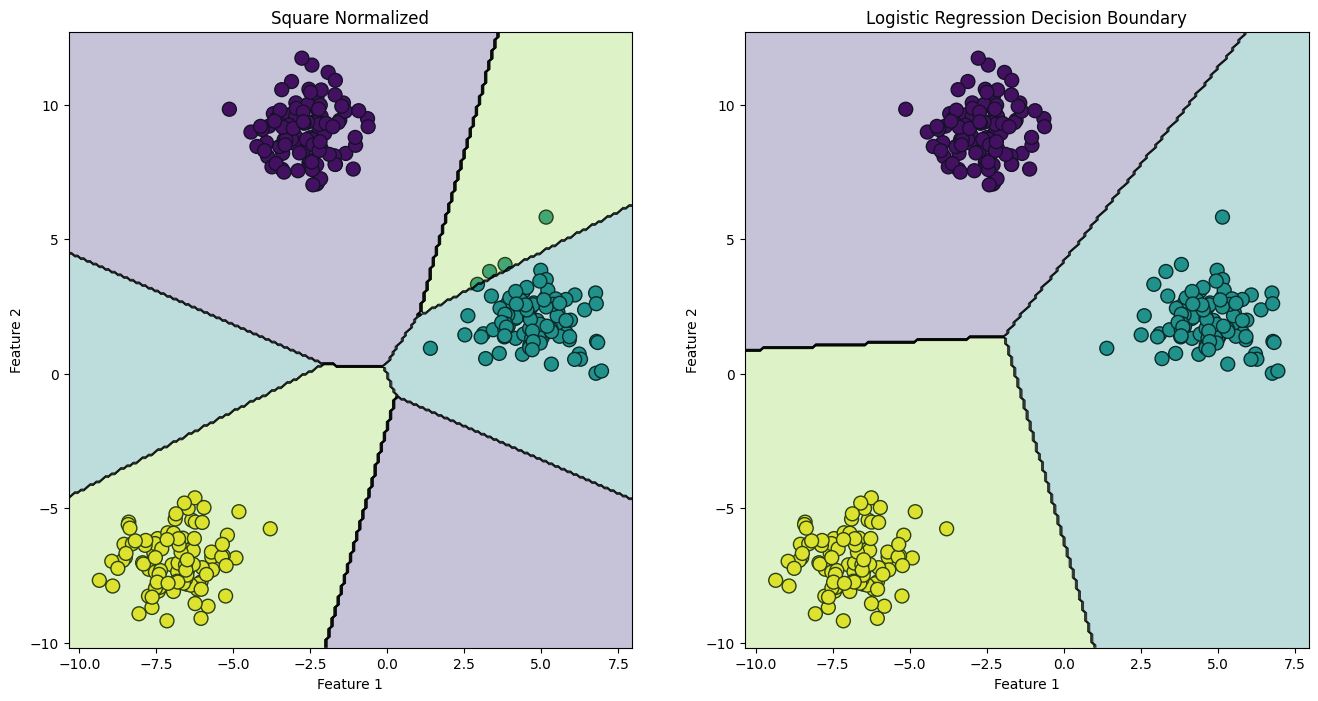

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

X, y = make_blobs(n_samples=300, centers=3, n_features=2, random_state=42)
y_one_hot = np.eye(3)[y]  # one-hot encoded labels

num_features = X.shape[1]
num_classes = y_one_hot.shape[1]
W = np.random.randn(num_features, num_classes)
b = np.zeros((1, num_classes))

learning_rate = 0.01
num_epochs = 1000

def squared_normalized_scores(scores):
    squared_scores = scores ** 2
    sum_squared_scores = np.sum(squared_scores, axis=1, keepdims=True)
    return squared_scores / sum_squared_scores

def mse_loss(predictions, targets):
    return np.mean((predictions - targets) ** 2)

for epoch in range(num_epochs):
    scores = np.dot(X, W) + b
    predictions = squared_normalized_scores(scores)

    loss = mse_loss(predictions, y_one_hot)
    
    grad_output = 2 * (predictions - y_one_hot) / y_one_hot.shape[0]
    
    grad_scores = grad_output * (2 * scores) / np.sum(scores ** 2, axis=1, keepdims=True)
    
    dW = np.dot(X.T, grad_scores)
    db = np.sum(grad_scores, axis=0, keepdims=True)
    
    W -= learning_rate * dW
    b -= learning_rate * db

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

print("Final weights:\n", W)
print("Final biases:\n", b)

def predict_squared_normalized(X, W, b):
    scores = np.dot(X, W) + b
    predictions = squared_normalized_scores(scores)
    return np.argmax(predictions, axis=1)

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
log_reg.fit(X, y)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', s=100)
ax.set_title('Square Normalized')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z_squared = predict_squared_normalized(np.c_[xx.ravel(), yy.ravel()], W, b)
Z_squared = Z_squared.reshape(xx.shape)

Z_log_reg = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z_log_reg = Z_log_reg.reshape(xx.shape)

ax.contourf(xx, yy, Z_squared, alpha=0.3, cmap='viridis', levels=np.arange(-0.5, 3.5, 1))
ax.contour(xx, yy, Z_squared, colors='k', linewidths=0.5)

ax2 = fig.add_subplot(122)
ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', s=100)
ax2.set_title('Logistic Regression Decision Boundary')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.contourf(xx, yy, Z_log_reg, alpha=0.3, cmap='viridis', levels=np.arange(-0.5, 3.5, 1))
ax2.contour(xx, yy, Z_log_reg, colors='k', linewidths=0.5)
fig.savefig('005.png')


## Distribution of errors

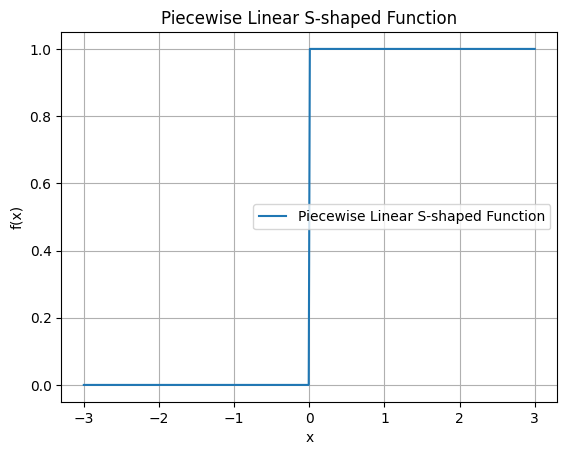

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def step(x, c):
    if x < c:
        return 0
    else:
        return 1

# Vectorize the function for array input
piecewise_linear_s_vectorized = np.vectorize(step)

# Generate input data
x = np.linspace(-3, 3, 400)
y = piecewise_linear_s_vectorized(x, 0)

# Plot the function
plt.plot(x, y, label='Piecewise Linear S-shaped Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.title('Piecewise Linear S-shaped Function')
plt.show()


Epoch 0, Loss: 20
Epoch 1, Loss: 18
Epoch 2, Loss: 16
Epoch 3, Loss: 14
Epoch 4, Loss: 12
Epoch 5, Loss: 10
Epoch 6, Loss: 8
Epoch 7, Loss: 6
Epoch 8, Loss: 4
Epoch 9, Loss: 2
threshold: -2.7755575615628914e-16


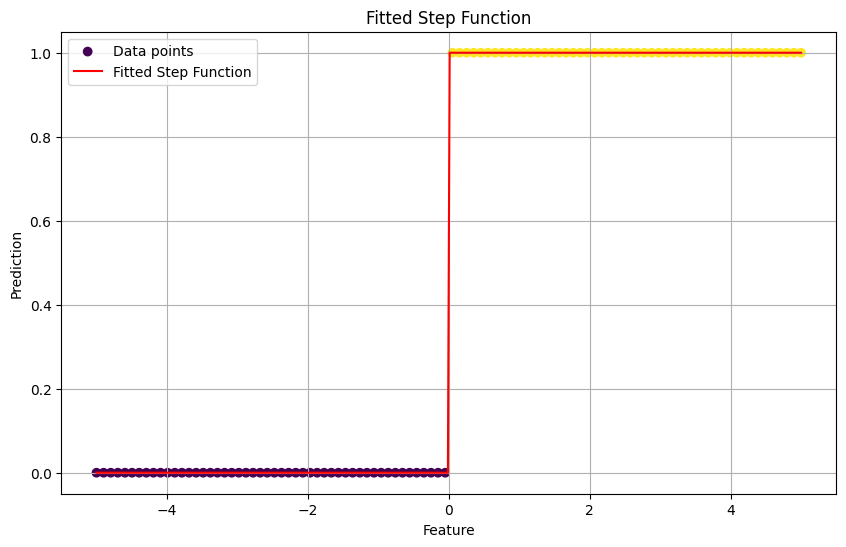

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the step function
def step_function(x, theta):
    return 1 * (x >= theta)

# Loss function
def loss(y, y_pred):
    return np.sum((y - y_pred) ** 2)

# Update function
def update_parameters(X, y, theta, current_loss, learning_rate=0.01):
    theta += learning_rate
    if loss(y, step_function(X, theta)) <= current_loss:
        return theta
    else:
        return theta - 2 * learning_rate

np.random.seed(14)
n_samples = 100
X = np.linspace(-5, 5, n_samples)
y = (X > 0).astype(int).reshape(n_samples,)

theta = -2

# Training loop
for epoch in range(10):
    y_pred = step_function(X, theta)
    current_loss = loss(y, y_pred)
    theta = update_parameters(X, y, theta, current_loss, learning_rate=0.2)
    print(f'Epoch {epoch}, Loss: {current_loss}')

print(f'threshold: {theta}')

# 2D plot of the fitted step function
plt.figure(figsize=(10, 6))

# Plot data points
plt.scatter(X, y, c=y, cmap='viridis', marker='o', label='Data points')

# Plot the step function decision boundary
x_values = np.linspace(X.min(), X.max(), 400)
y_values = step_function(x_values, theta)

plt.plot(x_values, y_values, color='r', label='Fitted Step Function')
plt.xlabel('Feature')
plt.ylabel('Prediction')
plt.title('Fitted Step Function')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
def modified_relu(x):
    return np.where(x < 0, 0, np.where(x > 1, 1, x))

def modified_relu_gradient(x):
    return np.where((x < 0) | (x > 1), 0, 1)

def snap(mod_log_reg):
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, c=y, cmap='bwr', marker='o', edgecolor='k', label='Data')

    x_values = np.linspace(np.min(X), np.max(X), 100)
    y_values = mod_log_reg.predict_proba(x_values)
    plt.plot(x_values, y_values, color='green', linewidth=2, label='Fitted Modified ReLU')

    plt.title('Modified ReLU')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.legend()
    plt.grid(True)
    plt.savefig(TEMPFILE_NAME)
    plt.close()

    return im.fromarray(np.asarray(im.open(TEMPFILE_NAME)))

class ModifiedLogisticRegression:
    def __init__(self, learning_rate=0.1, max_iter=1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples = len(X)
        self.weights = 0 + np.random.uniform(-1, 1)
        self.bias = 0 + np.random.uniform(-1, 1)

        images = []

        for _ in range(self.max_iter):

            images.append(snap(self))
            linear_output = X * self.weights + self.bias
            predicted_proba = modified_relu(linear_output)
            errors = y - predicted_proba

            d_weights = -np.dot(X.T, errors * modified_relu_gradient(linear_output)) / n_samples
            d_bias = -np.mean(errors * modified_relu_gradient(linear_output))

            self.weights -= self.learning_rate * d_weights
            self.bias -= self.learning_rate * d_bias

        return images

    def compute_loss(self, X, y):
        linear_output = X * self.weights + self.bias
        predicted_proba = modified_relu(linear_output)
        loss = np.mean((y - predicted_proba) ** 2)
        return loss
    
    def predict_proba(self, X):
        linear_output = X * self.weights + self.bias
        return modified_relu(linear_output)

    def predict(self, X):
        return np.round(self.predict_proba(X))

np.random.seed(14)
n_samples = 100
X = np.linspace(-5, 5, n_samples)
y = (X > 0).astype(int).reshape(n_samples,)

mod_log_reg = ModifiedLogisticRegression()
images = mod_log_reg.fit(X, y)

save_to_gif('004.gif', images, duration=50)

/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


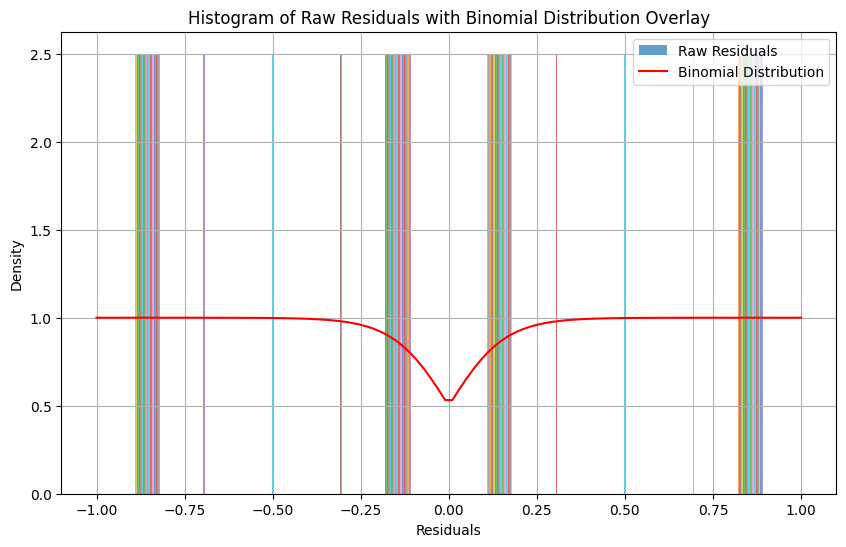

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import binom

# Generate synthetic data
np.random.seed(14)
n_samples = 100
X = np.linspace(-5, 5, n_samples).reshape(-1,1)
y = (X > 0).astype(int)

# Fit logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Predict probabilities
probabilities = model.predict_proba(X)[:, 1]

# Compute raw residuals
raw_residuals = y - probabilities

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(raw_residuals, bins=10, density=True, alpha=0.7, label='Raw Residuals')

# Generate a range of residuals for plotting the binomial PMF
residuals_range = np.linspace(-1, 1, 100)

# Calculate the binomial PMF for each residual
# Note: The binomial distribution is discrete, but we'll plot it as a continuous line for visualization purposes
binom_pmf = np.mean([binom.pmf(y, 1, prob) for prob, y in zip(probabilities, y)], axis=1)

# Plot binomial distribution
plt.plot(residuals_range, binom_pmf, 'r-', label='Binomial Distribution')

# Add labels and legend
plt.title('Histogram of Raw Residuals with Binomial Distribution Overlay')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
def f(x1, x2, C):
    return C * x1 - C * x2

COLORS = np.array(['blue', 'purple'])
X, Y = generate_line_data(DATA, 1, -1, 0)
Y[np.where(Y == 0)] = 1
Y[np.where(Y == 2)] = 0

def snap(C):
    xplot = np.linspace(-3, 3, 100)
    x, y = np.meshgrid(xplot, xplot)
    fig, ax = plt.subplots()
    errors = Y - sigmoid(f(X[:, 0], X[:, 1], C))
    ax.hist(errors, bins=100)
    ax.set_xlabel('$\\sigma - Y$', fontsize=15)
    ax.set_title(r'$\sigma(C x_1 - C x_2)$'.replace("C", f'{C:.2f}'), fontsize=40)
    fig.savefig(TEMPFILE_NAME)
    plt.close()

    return im.fromarray(np.asarray(im.open(TEMPFILE_NAME)))

images = []

for i in range(1, 40):
    images.append(snap(i/10))

save_to_gif("001.gif", images, 10)

## Sliding Window

In [17]:
np.random.seed(1)
n_samples = 20
X = np.linspace(-5, 5, n_samples) + np.random.uniform(-1, 1, n_samples)
y = (X > 0).astype(int).reshape(n_samples,)
COLORS = np.array(['blue', 'purple'])

def snap(bs, proportions):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(X, y, color=COLORS[y.tolist()])
    ax.plot(bs, proportions, '-o')
    ax.axvline(b-1)
    ax.axvline(b+1)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.1, 1.1)
    fig.savefig(TEMPFILE_NAME)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE_NAME)))


images = []
bs = []
proportions = []
for b in np.linspace(-4, 4, 100):
    bs.append(b)
    in_range = np.where(np.logical_and(X < b + 1, X > b - 1))
    x_in_range = X[in_range]
    y_in_range = y[in_range]
    proportions.append(np.mean(y_in_range))
    images.append(snap(bs, proportions))

save_to_gif('sliding_window.gif', images, duration=50)

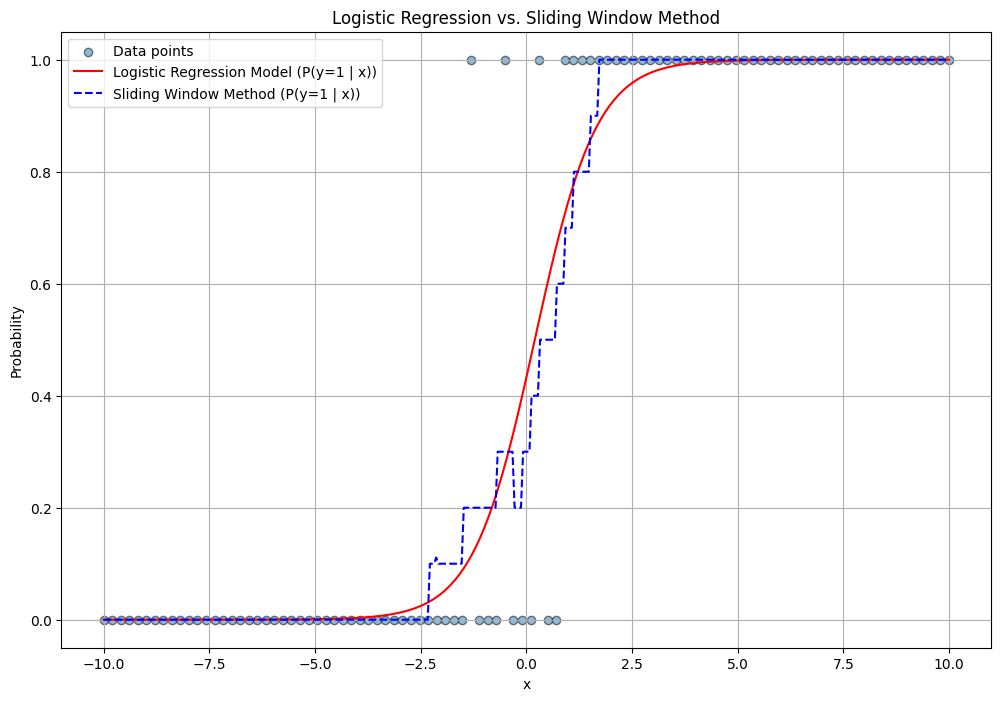

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Generate synthetic binary data
np.random.seed(0)
x = np.linspace(-10, 10, 100)
y = (x + np.random.randn(100) > 0).astype(int)

# Logistic regression model
model = LogisticRegression()
x_reshaped = x.reshape(-1, 1)
model.fit(x_reshaped, y)

# Generate probability predictions from logistic regression
x_test = np.linspace(-10, 10, 400).reshape(-1, 1)
y_prob_lr = model.predict_proba(x_test)[:, 1]

# Sliding window method
window_size = 2.0
y_prob_sw = np.zeros_like(x_test.flatten())
for i in range(len(x_test)):
    window_start = x_test[i] - window_size / 2
    window_end = x_test[i] + window_size / 2
    in_window = (x >= window_start) & (x <= window_end)
    y_prob_sw[i] = np.mean(y[in_window])

# Plotting
plt.figure(figsize=(12, 8))

# Plot data points
plt.scatter(x, y, label='Data points', alpha=0.5, edgecolors='k')

# Plot logistic regression model's probability curve
plt.plot(x_test, y_prob_lr, label='Logistic Regression Model (P(y=1 | x))', color='red')

# Plot sliding window method's probability curve
plt.plot(x_test, y_prob_sw, label='Sliding Window Method (P(y=1 | x))', color='blue', linestyle='--')

# Labels and title
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Logistic Regression vs. Sliding Window Method')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression


def snap(sample_size):
    # Generate synthetic binary data
    np.random.seed(0)
    x = np.linspace(-10, 10, sample_size)
    y = (x + np.random.randn(sample_size) > 0).astype(int)

    # Logistic regression model
    model = LogisticRegression()
    x_reshaped = x.reshape(-1, 1)
    model.fit(x_reshaped, y)

    # Generate probability predictions from logistic regression
    x_test = np.linspace(-10, 10, 400).reshape(-1, 1)
    y_prob_lr = model.predict_proba(x_test)[:, 1]

    probit_model = sm.Probit(y, sm.add_constant(x_reshaped)).fit(verbose=0)
    y_probit = probit_model.predict(sm.add_constant(x_test))

    # Sliding window method
    window_size = 2.0
    y_prob_sw = np.zeros_like(x_test.flatten())
    for i in range(len(x_test)):
        window_start = x_test[i] - window_size / 2
        window_end = x_test[i] + window_size / 2
        in_window = (x >= window_start) & (x <= window_end)
        y_prob_sw[i] = np.mean(y[in_window])

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(x, y, alpha=0.5, edgecolors='k')
    ax.plot(x_test, y_prob_lr, label='Logistic Regression Model', color='red')
    ax.plot(x_test, y_probit, label='Probit Regression Model', color='green')
    # Plot sliding window method's probability curve
    ax.plot(x_test, y_prob_sw, label='Sliding Window Method', color='blue', linestyle='--')

    # Labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('Probability')
    ax.set_title('Comparison of Different Models')
    ax.legend(loc='center right')
    ax.grid(True)
    fig.savefig(TEMPFILE_NAME)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE_NAME)))

images = []
for i in range(1, 50):
    images.append(snap(int(100 * (i / 10))))

save_to_gif('sample_size_increase.gif', images, duration=200)

/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=Perfe

         Current function value: 0.000000
         Iterations: 35
         Current function value: 0.000000
         Iterations: 35


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=Perfe

         Current function value: 0.000000
         Iterations: 35
         Current function value: 0.000000
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.048523
         Iterations 12


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparati

Optimization terminated successfully.
         Current function value: 0.150635
         Iterations 9
         Current function value: 0.000000
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.098996
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.062449
         Iterations 11


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword ar

Optimization terminated successfully.
         Current function value: 0.097890
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.067385
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.029115
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.038359
         Iterations 12


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword ar

Optimization terminated successfully.
         Current function value: 0.043924
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.081816
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.068008
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.042214
         Iterations 12


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword ar

Optimization terminated successfully.
         Current function value: 0.070293
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.098496
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080431
         Iterations 10


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword ar

Optimization terminated successfully.
         Current function value: 0.081201
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.074203
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077276
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078550
         Iterations 10


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword ar

Optimization terminated successfully.
         Current function value: 0.111034
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.107555
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099392
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079672
         Iterations 10


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword ar

Optimization terminated successfully.
         Current function value: 0.078805
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083423
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093834
         Iterations 10


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword ar

Optimization terminated successfully.
         Current function value: 0.097977
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094466
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098986
         Iterations 10


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword ar

Optimization terminated successfully.
         Current function value: 0.106901
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101495
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087048
         Iterations 10


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword ar

Optimization terminated successfully.
         Current function value: 0.059728
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.070825
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.069614
         Iterations 11


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword ar

Optimization terminated successfully.
         Current function value: 0.081505
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079255
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101904
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095972
         Iterations 10


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword ar

Optimization terminated successfully.
         Current function value: 0.101405
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097268
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085733
         Iterations 10


/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: 0.085022
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080992
         Iterations 10


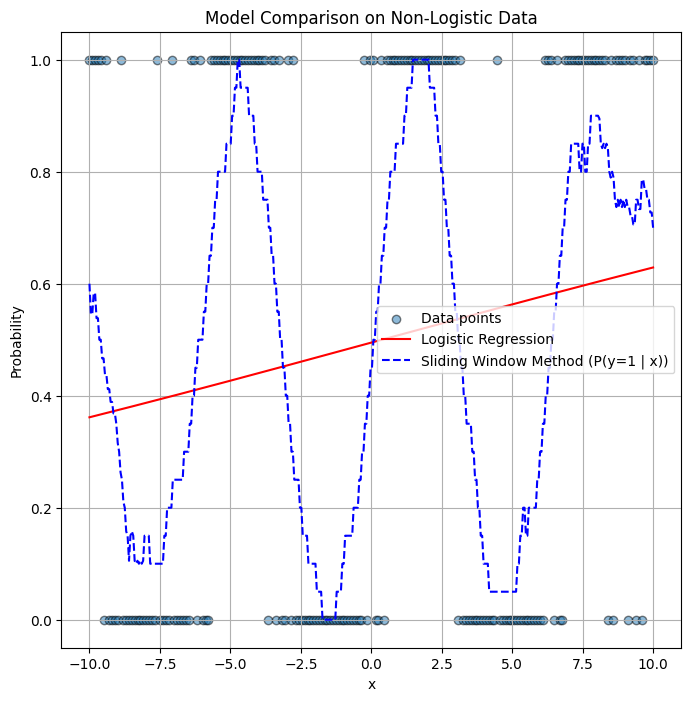

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Generate synthetic data
np.random.seed(0)
x = np.linspace(-10, 10, 200)
y = (np.sin(x) + np.random.normal(scale=0.5, size=x.shape) > 0).astype(int)

# Fit logistic regression model
log_reg = LogisticRegression()
x_reshaped = x.reshape(-1, 1)
log_reg.fit(x_reshaped, y)
y_prob_log_reg = log_reg.predict_proba(x_reshaped)[:, 1]

window_size = 2.0
y_prob_sw = np.zeros_like(x_test.flatten())
for i in range(len(x_test)):
    window_start = x_test[i] - window_size / 2
    window_end = x_test[i] + window_size / 2
    in_window = (x >= window_start) & (x <= window_end)
    y_prob_sw[i] = np.mean(y[in_window])

# Visualize the dataset and model fits
plt.figure(figsize=(8, 8))

# Plot data points
plt.scatter(x, y, label='Data points', alpha=0.5, edgecolors='k')

# Plot logistic regression model's probability curve
plt.plot(x, y_prob_log_reg, label='Logistic Regression', color='red')

# Plot decision tree model's probability curve
plt.plot(x_test, y_prob_sw, label='Sliding Window Method (P(y=1 | x))', color='blue', linestyle='--')

# Labels and title
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Model Comparison on Non-Logistic Data')
plt.legend(loc='center right')
plt.grid(True)
plt.savefig('006.png')
plt.show()


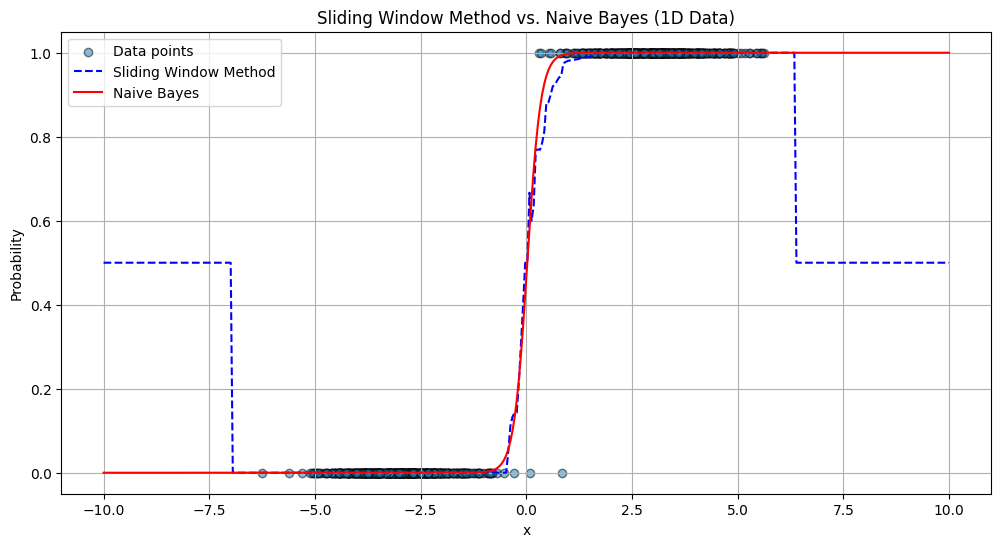

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Generate synthetic data with two Gaussian blobs along one dimension
n_samples = 1000
centers = np.array([-3, 3]).reshape(-1, 1)
X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=1.0, random_state=42, n_features=1)

# Sliding window method
window_size = 1.5
x_test = np.linspace(-10, 10, 400).reshape(-1, 1)
y_prob_sw = np.zeros_like(x_test.flatten())
for i in range(len(x_test)):
    window_start = x_test[i] - window_size / 2
    window_end = x_test[i] + window_size / 2
    in_window = (X.flatten() >= window_start) & (X.flatten() <= window_end)
    if np.sum(in_window) > 0:
        y_prob_sw[i] = np.mean(y[in_window])
    else:
        y_prob_sw[i] = 0.5  # Default to 0.5 if no points in window

# Fit Naive Bayes model
nb = GaussianNB()
nb.fit(X, y)
y_prob_nb = nb.predict_proba(x_test)[:, 1]

# Visualize the dataset and probability estimates
plt.figure(figsize=(12, 6))

# Plot data points
plt.scatter(X, y, label='Data points', alpha=0.5, edgecolors='k')

# Plot sliding window method's probability curve
plt.plot(x_test, y_prob_sw, label='Sliding Window Method', color='blue', linestyle='--')

# Plot Naive Bayes model's probability curve
plt.plot(x_test, y_prob_nb, label='Naive Bayes', color='red')

# Labels and title
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Sliding Window Method vs. Naive Bayes (1D Data)')
plt.legend()
plt.grid(True)
plt.show()
